# Iterative $\alpha$-(De)Blending

In [2]:
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_circles, make_moons, make_swiss_roll
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
try:
    from google.colab import drive
except:
    ROOT = '.'
else:
    drive.mount('/content/drive')
    ROOT = '/content/drive/My Drive/Informatique/Notebooks'

___

## 2D

#### Generate data.

In [3]:
def sample_x0(size, scale=0.5):
    x = scale * np.random.randn(size, 2)
    return x
x0 = sample_x0(1000)

In [4]:
def sample_x1(size, noise=0.1, factor=0.1):
    x, _ = make_circles(n_samples=size, noise=noise, factor=factor)
    return x
x1 = sample_x1(1000)

#### Visualize data.

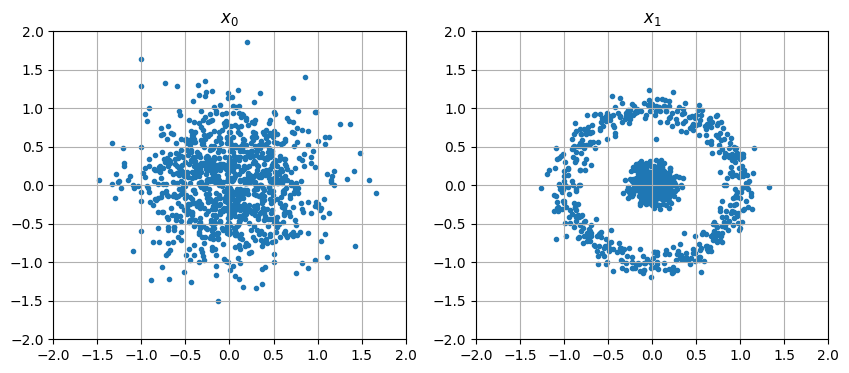

In [5]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(x0[:,0], x0[:,1], marker='.')
axs[0].grid()
axs[0].set_title('$x_0$')
axs[0].set_xlim([-2, 2]); axs[0].set_ylim([-2, 2]);

axs[1].scatter(x1[:,0], x1[:,1], marker='.')
axs[1].grid()
axs[1].set_title('$x_1$')
axs[1].set_xlim([-2, 2]); axs[1].set_ylim([-2, 2]);

plt.show()

In [6]:
SIZE = 10000
dataset_x0 = torch.Tensor(sample_x0(SIZE))
dataset_x1 = torch.Tensor(sample_x1(SIZE))
print(f"{dataset_x0.shape = }")
print(f"{dataset_x1.shape = }")

dataset_x0.shape = torch.Size([10000, 2])
dataset_x1.shape = torch.Size([10000, 2])


#### Define neural network.

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Architecture
class MLP(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.linear1 = torch.nn.Linear(2+1,64) # input = (x_alpha, alpha)
        self.linear2 = torch.nn.Linear(64, 64)
        self.linear3 = torch.nn.Linear(64, 64)
        self.linear4 = torch.nn.Linear(64, 64)
        self.output  = torch.nn.Linear(64, 2)  # output = (x_1 - x_0)
        self.relu = torch.nn.ReLU()
        self.device = device

    def forward(self, x, alpha):
        res = torch.cat([x, alpha], dim=1).to(self.device)
        res = self.relu(self.linear1(res))
        res = self.relu(self.linear2(res))
        res = self.relu(self.linear3(res))
        res = self.relu(self.linear4(res))
        res = self.output(res)
        return res

In [9]:
model = MLP(device=DEVICE).to(DEVICE)

In [10]:
y = model(x=torch.randn(64, 2).to(DEVICE), alpha=torch.rand(64, 1).to(DEVICE))
print(y.shape)

torch.Size([64, 2])


In [11]:
PATH = ROOT + '/models/IADB-2D.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Training loop.

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

In [13]:
BATCH_SIZE = 256
NUM_EPOCHS = 0 #10000

In [14]:
for epoch in tqdm(range(NUM_EPOCHS)):

    # Shuffle datasets
    permutation = torch.randperm(SIZE)
    permutation_x0 = dataset_x0[permutation].to(DEVICE)
    permutation_x1 = dataset_x1[permutation].to(DEVICE)

    # Parse datasets
    for batch_i in range(0, SIZE-BATCH_SIZE, BATCH_SIZE):

        batch_x0 = permutation_x0[batch_i : batch_i+BATCH_SIZE]
        batch_x1 = permutation_x1[batch_i : batch_i+BATCH_SIZE]
        batch_alpha = torch.rand(BATCH_SIZE, 1, device=DEVICE)
        batch_xa = (1 - batch_alpha) * batch_x0 + batch_alpha * batch_x1

        output = model(batch_xa, batch_alpha)
        target = batch_x1 - batch_x0
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


0it [00:00, ?it/s]

In [15]:
torch.save(model.state_dict(), PATH)

#### Sampling loop.

  0%|          | 0/101 [00:00<?, ?it/s]

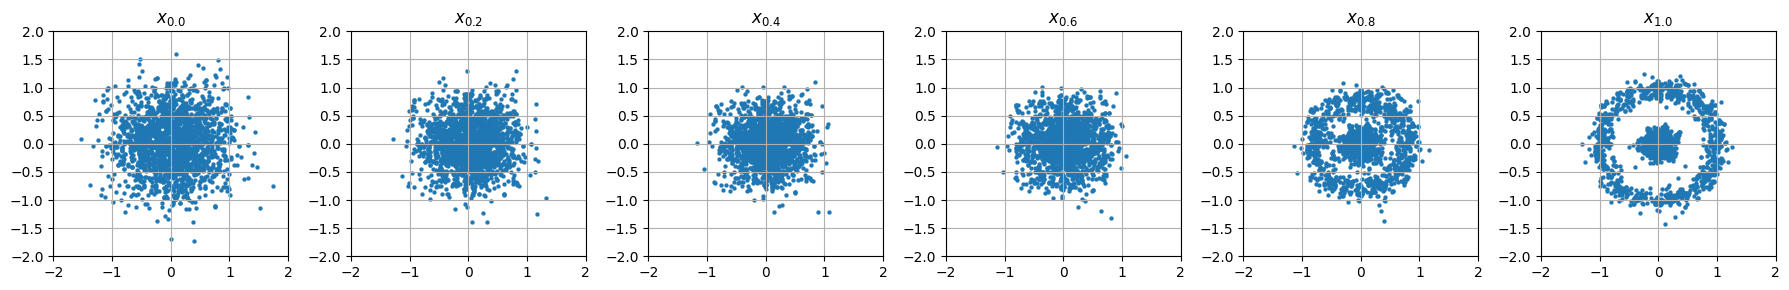

In [16]:
with torch.no_grad():

    NUM_PLOTS = 5
    fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(18,3))

    # Starting point x_a = x_0
    BATCH_SIZE = 2048
    batch_x0 = dataset_x0[np.random.randint(0, SIZE, BATCH_SIZE)].to(DEVICE)
    batch_xa = batch_x0.clone()

    # Loop
    T = 100
    for t in tqdm(range(T+1)):

        # Current alpha value
        alpha = t/T
        batch_a = alpha * torch.ones(BATCH_SIZE, 1, device=DEVICE)
        # Update
        batch_xa = batch_xa + (1/T) * model(batch_xa, batch_a)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(batch_xa.cpu().data.numpy()[:,0], batch_xa.cpu().data.numpy()[:,1], marker='.', linewidth=0.1)
            axs[i].set_title(f"$x_{{{alpha}}}$")
            axs[i].set_xlim([-2, 2]);
            axs[i].set_ylim([-2, 2]);
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()

___

## MNIST

#### Load dataset.

In [17]:
BATCH_SIZE = 64
dataset = torchvision.datasets.MNIST(root = './data/',
                                       train = True,
                                       download = True,
                                       transform = torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Pad(2),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, shuffle=True)

#### Visualize data.

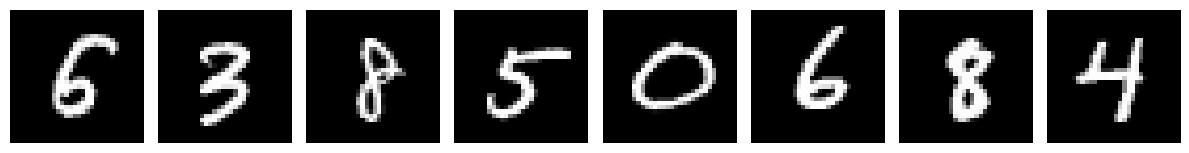

In [18]:
num_plots = 8
fig, axs = plt.subplots(1, num_plots, figsize=(12,4))
for batch_i, (batch_x, batch_y) in enumerate(dataloader):
    for i, x in enumerate(batch_x[:num_plots]):
        axs[i].imshow(x[0].data.numpy(), cmap='gray')
        axs[i].axis('off')
    break
fig.tight_layout()
plt.show()

#### Neural network.

In [19]:
class UNet(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()

        # Block Down 1
        self.block1_conv1 = nn.Conv2d( 2, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.block1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2)
        # Block Down 2
        self.block2_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.block2_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2)
        # Block Down 3
        self.block3_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.block3_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.block3_conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.block3_conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2)
        # Block Up 3
        self.block3_up1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2, output_padding=1)
        self.block3_up2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        # Block Up 2
        self.block2_up1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2, output_padding=1)
        self.block2_up2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        # Block Up 1
        self.block1_up1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=2, output_padding=1)
        self.block1_up2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        # Output
        self.conv_output = nn.Conv2d(64, 1, kernel_size=1, padding=0, stride=1)
        # Activation function
        self.relu = nn.ReLU()
        #
        self.device = device

    def forward(self, x, alpha):

        # Input
        b0 = torch.cat([x, alpha[:,None,None,None].repeat(1,1,32,32)], dim=1).to(self.device)

        b1_c1 = self.relu(self.block1_conv1(b0))
        b1_c2 = self.relu(self.block1_conv2(b1_c1))

        b2_c1 = self.relu(self.block2_conv1(b1_c2))
        b2_c2 = self.relu(self.block2_conv2(b2_c1))

        b3_c1 = self.relu(self.block3_conv1(b2_c2))
        b3_c2 = self.relu(self.block3_conv2(b3_c1))
        b3_c3 = self.relu(self.block3_conv3(b3_c2)) + b3_c1
        b3_c4 = self.relu(self.block3_conv4(b3_c3))

        u2_c1 = self.relu(self.block3_up1(b3_c4)) + b3_c3
        u2_c2 = self.relu(self.block3_up2(u2_c1)) + b2_c2

        u1_c1 = self.relu(self.block2_up1(u2_c2)) + b1_c2
        u1_c2 = self.relu(self.block2_up2(u1_c1))

        u0_c1 = self.relu(self.block1_up1(u1_c2)) + b1_c1
        u0_c2 = self.relu(self.block1_up2(u0_c1))

        output = self.conv_output(u0_c2)

        return output

In [20]:
model = UNet(device=DEVICE).to(DEVICE)

In [21]:
y = model(x=torch.randn(64,1,32,32).to(DEVICE), alpha=torch.rand(64).to(DEVICE))
print(y.shape)

torch.Size([64, 1, 32, 32])


In [26]:
PATH = ROOT + '/models/IADB-MNIST.pt'
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

<All keys matched successfully>

#### Training Loop.

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss(reduction='mean')

In [28]:
NUM_EPOCHS = 0 #20

In [29]:
for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_i, (batch_x, _) in enumerate(dataloader):
        batch_x = batch_x.to(DEVICE)

        batch_x0 = torch.randn(BATCH_SIZE, 1, 32, 32, device=DEVICE)
        batch_x1 = -1 + 2*batch_x

        batch_a = torch.rand(BATCH_SIZE, device=DEVICE)
        batch_xa = (1 - batch_a.view(BATCH_SIZE,1,1,1)) * batch_x0 + batch_a.view(BATCH_SIZE,1,1,1) * batch_x1

        output = model(batch_xa, batch_a)
        target = batch_x1 - batch_x0
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


0it [00:00, ?it/s]

In [30]:
torch.save(model.state_dict(), PATH)

  0%|          | 0/101 [00:00<?, ?it/s]

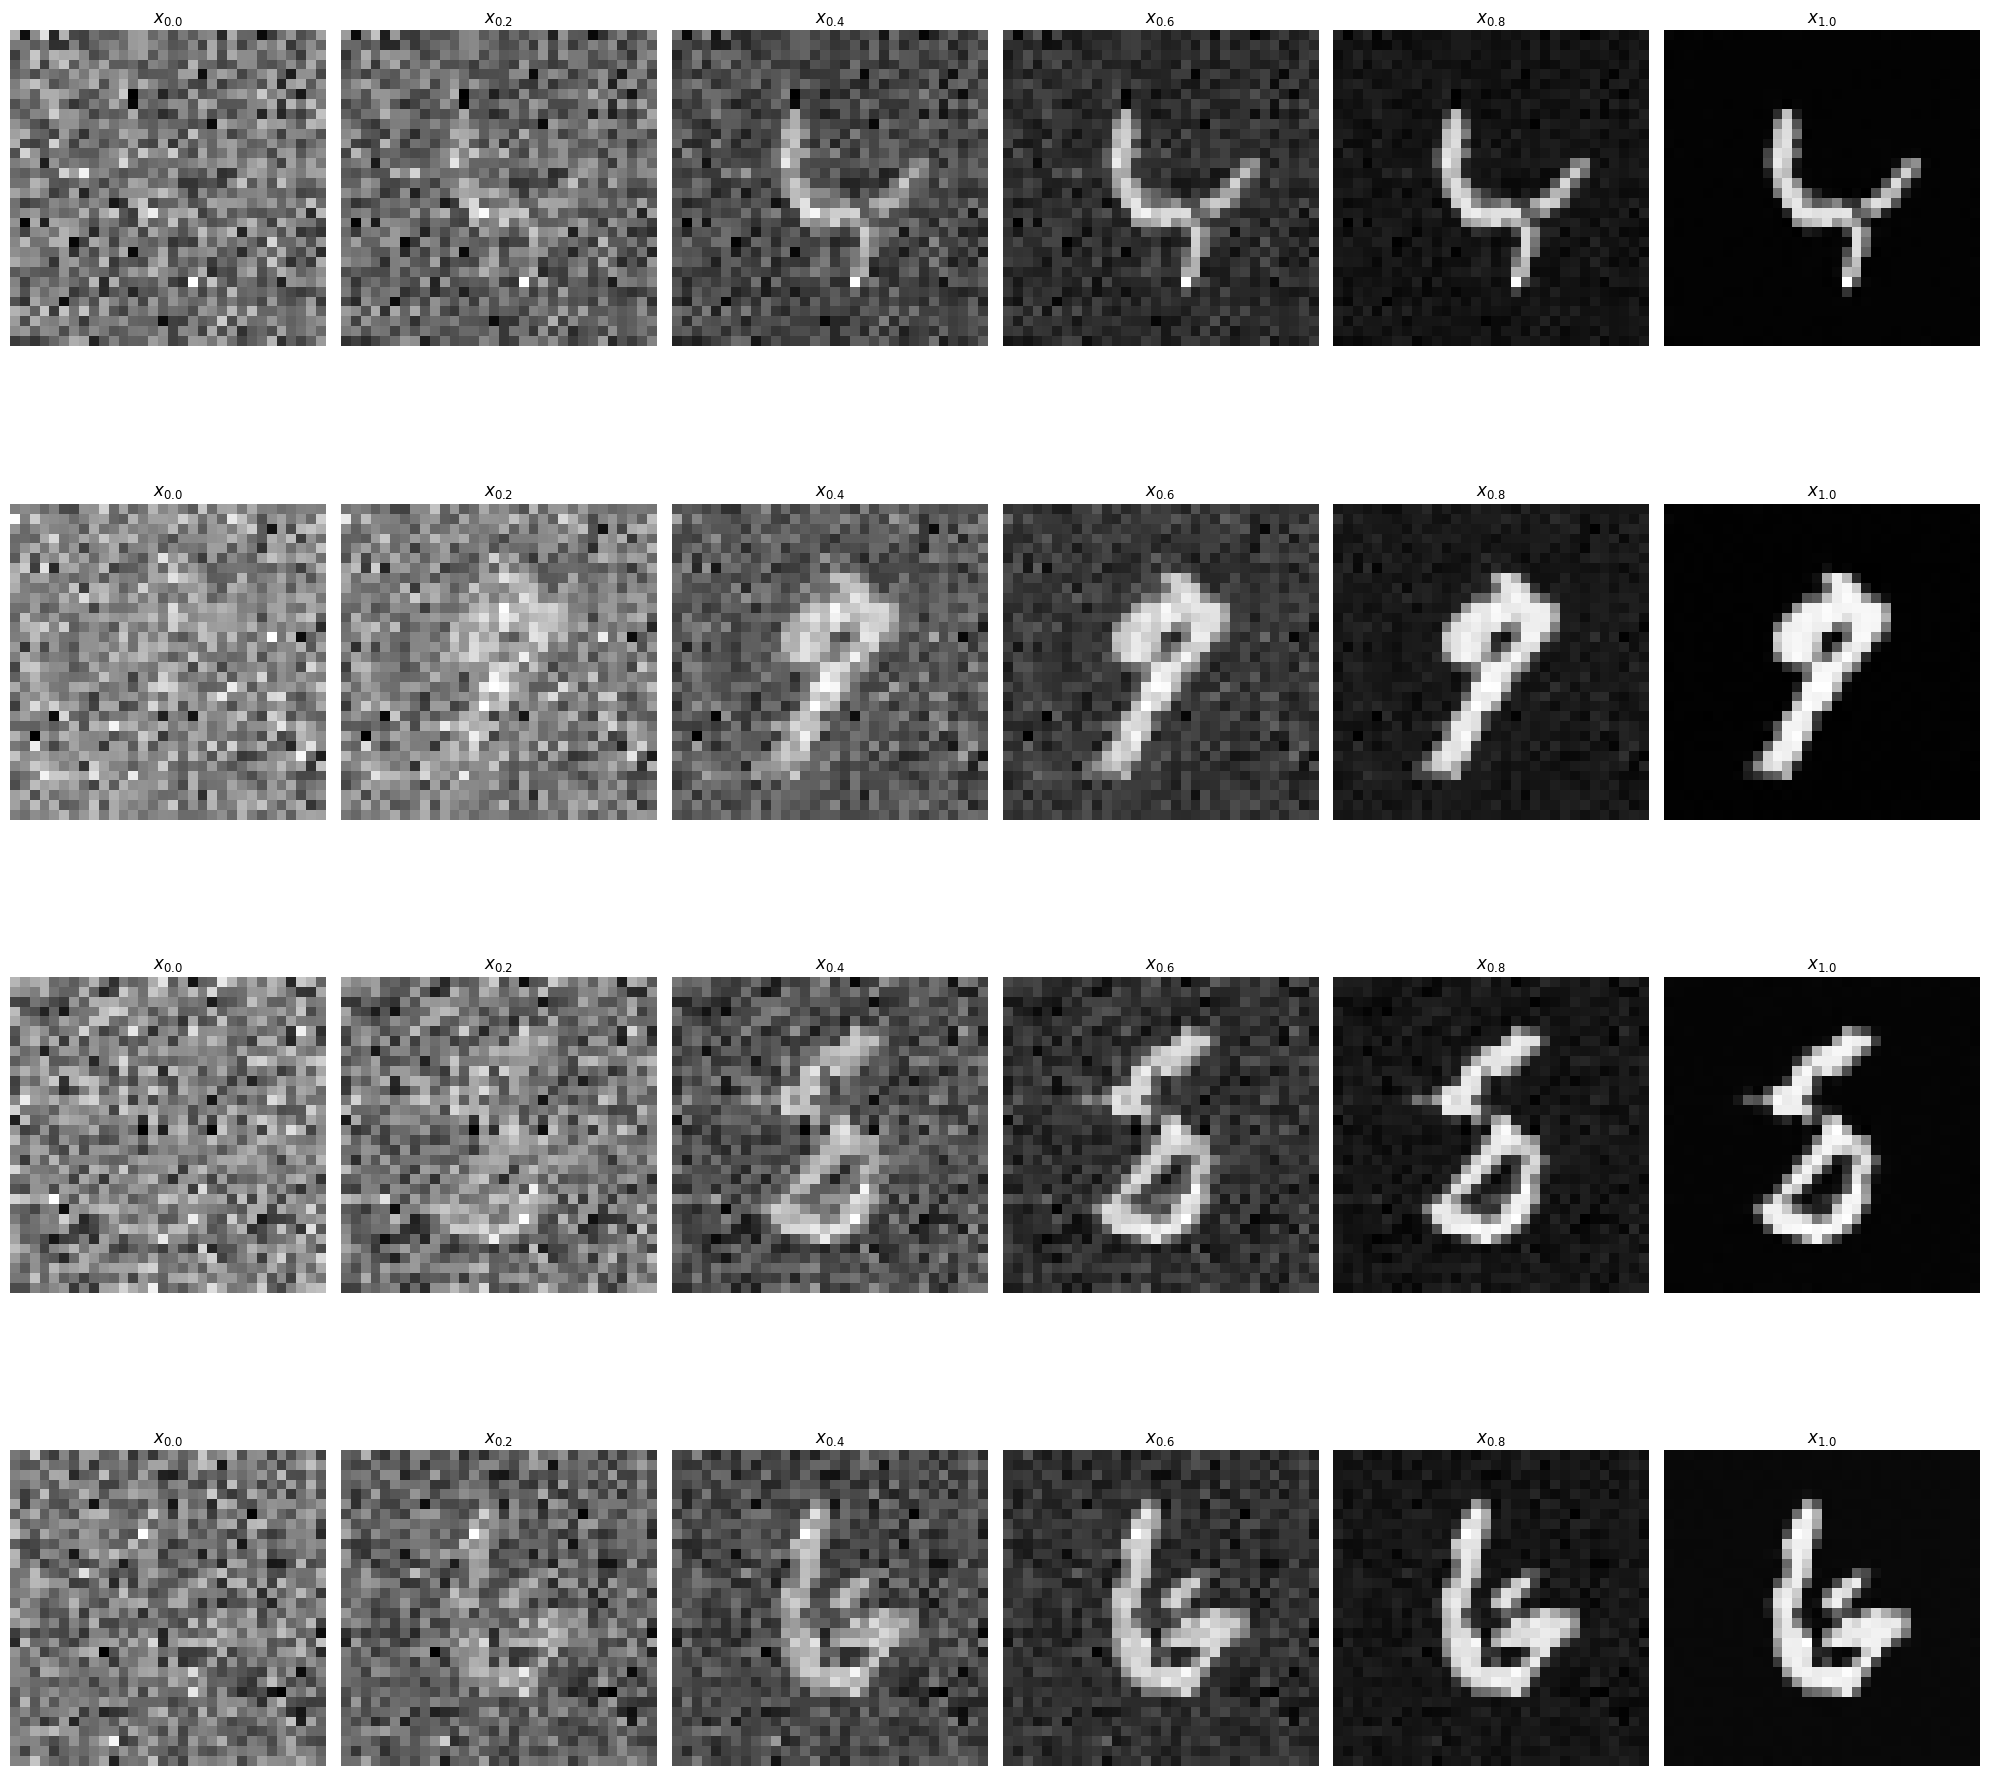

In [31]:
with torch.no_grad():
    BATCH_SIZE = 4
    NUM_PLOTS = 5
    fig, axs = plt.subplots(BATCH_SIZE, NUM_PLOTS+1, figsize=(20,20))

    # Starting point x_a = x_0
    batch_x0 = torch.randn(BATCH_SIZE, 1, 32, 32, device=DEVICE)
    batch_xa = batch_x0.clone()
    # Loop
    T = 100
    for t in tqdm(range(T+1)):

        # Current alpha value
        alpha = (t/T)
        batch_a = alpha * torch.ones(BATCH_SIZE, device=DEVICE)
        # Update
        batch_xa = batch_xa + (1/T) * model(batch_xa, batch_a)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            for b in range(BATCH_SIZE):
              i = t//(T//NUM_PLOTS)
              axs[b,i].imshow(batch_xa[b,0].cpu().data.numpy(), cmap='gray')
              axs[b,i].set_title(f"$x_{{{alpha}}}$")
              axs[b,i].axis('off')

    fig.tight_layout()
    plt.show()